Qu Iteration
===

This notebook implements the partial points annotation in the Qu paper. First imports are made, then general parameters are initiated.
Then the first iteration is prepared.

- Manual annotations are converted into masks with weights in them
- Then these masks are used in the initial training step
- After training this model, it is used to make a prediction
- This prediction is put through a thresholding function to create new weights for the same masks
- These weights are reapplied to the point annotations from before
- A new training session starts
- Points 3 through 7 are repeated a few times until it converges.


In [36]:

import tensorflow as tf
import numpy as np
from numpy import random
import os
from tqdm import tqdm
import cv2
from shutil import copy

import mask_prediction.unet_semantics as model_setup
import mask_prediction.data_retrievals as data
import mask_prediction.apply_weights as weights
import matplotlib.pyplot as plt

from glob import glob

print('Imports succesful!')


Imports succesful!


In [37]:

def dice_coeff(y_true, y_pred):
    """
    Measures the dice coefficient
    :param y_true: The true image for validation.
    :param y_pred: The image predicted by the network
    :return: Dice coefficient. The closer to one, the more the images are alike.
    """
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    """
    returns a dice coefficient which can be used as a loss parameter (aka, the closer to zero, the better)
    :param y_true: The true image for validation
    :param y_pred: The predicted image from the network
    :return: Dice loss, the closer to zero, the better.
    """
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def dice_loss_weighted(y_true, y_pred):
    y0, y1, y2 = tf.split(y_true, [1, 1, 1], 3)
    # tf.print(tf.shape(y_pred))

    y_pred_weighted = tf.multiply(y_pred, y1)
    y_true_weighted = tf.multiply(y2, y1)

    loss = dice_loss(y_true_weighted, y_pred_weighted)
    return loss


def bce_dice_loss(y_true, y_pred):
    """
    Returns the sum of the binary cross entropy score and the dice loss score
    :param y_true: The true image for validation
    :param y_pred: The predicted image from the network
    :return: bce dice loss score
    """
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

    return loss


def bce_dice_loss_weighted(y_true, y_pred):
    y_mask, y_weights, y_amplify = tf.split(y_true, [1, 1, 1], 3)
    # tf.print(y2)

    y_pred_weighted = tf.multiply(y_pred, y_weights)
    y_true_weighted = tf.multiply(y_mask, y_weights)

    # tf.print(y_true_weighted)

    loss = tf.keras.losses.binary_crossentropy(y_true_weighted, y_pred_weighted) + dice_loss(y_true_weighted,
                                                                                             y_pred_weighted)

    return loss


def MSE_loss_weighted(y_true, y_pred):
    y_mask, y_weights, y_amplify = tf.split(y_true, [1, 1, 1], 3)
    # tf.print(y_mask)

    y_amplify = tf.add(tf.multiply(y_amplify, 9.0), 1.0)

    y_pred_weighted = tf.multiply(y_pred, y_weights)
    y_true_weighted = tf.multiply(y_mask, y_weights)
    relevant_pixels = tf.reduce_sum(y_weights)
    relevant_pixels = tf.add(relevant_pixels, 1.0)
    # tf.print(relevant_pixels)

    loss_img_1 = tf.square(tf.subtract(y_pred_weighted, y_true_weighted))
    loss_img_2 = tf.multiply(y_amplify, loss_img_1)
    loss = tf.divide(tf.reduce_sum(loss_img_2), relevant_pixels)

    return loss

In [38]:
##### GPU setup #####
os.environ["CUDA_VISIBLE_DEVICES"]="0"    #chose which GPU to use (0-3)

##### CPU setup #####
os.environ['MKL_NUM_THREADS'] = '20'     #chose the amount of CPUs to use, idk if this is working right now?
os.environ['GOTO_NUM_THREADS'] = '20'    #however, maybe works if GPU is not present/working
os.environ['OMP_NUM_THREADS'] = '20'
os.environ['openmp'] = 'True'

Parameter Initiation
---

Below, the image parameters are explained and initiated. Then, the parameters for this run are initiated. These will be maintained for all training sessions.
Be aware that especially in the Qu implementation, training with secondary data will result in vastly different patterns in the ultimate predictions. We'll have to see to what extent this is still true after a few rounds of conversion.

One thing that might need expanding on is how to split the training/validation split and how datasets are selected to pull data from.
Right now, only one dataset can be pulled from, and it pulls from the Collected folder in the file structure, which only contains zoom level 3 images.
What's more, the train/validation split is done randomly with no seed.

The folders themselves have to be rearranged at some point.

In [39]:
##### General variables #####
IMG_SIZE = 1024     #size in pixels of 1 EM tile
BATCH_SIZE = 4          #How many images to take in at once on the GPU.

##### Parameters of this particular run #####
model_name = 'qu_base_em_predho_second'
TRAIN_WITH_FM = True            #Use the FM data when training. Creates model with either 3 (True) or 1 (False) input channels.
normalize = True                #Whether to normalize the secondary data coming in
Ho_adjust = False               #Threshold the Hoechst for the purpose of amplification.
PATIENCE = 50                   #How many epochs with no discernable difference in loss to wait before prematurely terminating training.
TRAIN_TEST_SPLIT = .8           #What percentage of available mask images will be used as training data. The inverse will be used as validation data.
iter_count = 3
area_thresh_scalar = 2

size_filter = 3e7       #area in pixels which has to cover the weights image for it to be used in training. (pixel values range from 0 to 255)
pnt_ratio = .5          #ratio of blobs which will be used in the final image.

##### Folders that will be used in this run #####

dataset = 'RL012'
ini_data_path = 'X:\\BEP_data\\'#File containing data structure
mask_folder = 'X:\\BEP_data\\Predict_backups\\sup_base_emho_2021-05-20_08-58-13\\Output\\'      #Folder containing manually annotated masks
train_folder = 'X:\\BEP_data\\Annotation_Iteration\\Train_set'#Folder from which the model will collect training images
test_folder = 'X:\\BEP_data\\Annotation_Iteration\\Test_set'   #Folder from which the model will collect validation images
prt_ann_folder = 'X:\\BEP_data\\Partial Annotation\\temp'#Folder in which the weighted masks are stored that are used in partial annotation.
em_folder = 'X:\\BEP_data\\{}\\EM'.format(dataset)
ho_folder = 'X:\\BEP_data\\{}\\Hoechst'.format(dataset)
mask_list =  glob(mask_folder + '\\*.png')              #Glob string filtering which masks to take.
predict_folder = 'X:\\BEP_data\\Annotation_Iteration\\Predict_set'

print('Loaded all variables.')
print('This run will use {} masks with EM input and {} {} {}'.format('weighted', ('no other data', 'Hoechst data, which is')[TRAIN_WITH_FM], (' ', 'normalized,')[TRAIN_WITH_FM*normalize], (' ', 'thresholded')[TRAIN_WITH_FM*Ho_adjust]))


Loaded all variables.
This run will use weighted masks with EM input and Hoechst data, which is normalized,  


In [40]:
data_paths = (train_folder, test_folder, em_folder, ho_folder, mask_folder)
use_em = not TRAIN_WITH_FM

def choice(str_list, percent, seed=4):
    np.random.seed(seed)
    random.shuffle(str_list)
    cut = int(len(str_list) * percent)
    return str_list[:cut], str_list[cut:]

print('Converting masks to weights...')

for image_name in glob(prt_ann_folder + '\\*.png'):
    os.remove(image_name)


radius_array = weights.get_radius_sample(mask_folder)
mean_diam = 2*np.mean(radius_array, dtype=int)
print('Converting {} images'.format(len(os.listdir(mask_folder))))

point_mask_list = weights.convert_partial_annotation(mask_folder, prt_ann_folder, mean_diam, IMG_SIZE=IMG_SIZE, pnt_ratio=pnt_ratio, size_filter=size_filter, glob_str='*.png')

print('Done, shuffling datasets...')

train_list, test_list = choice(point_mask_list, TRAIN_TEST_SPLIT)
train_list.sort()
test_list.sort()

print('Done, populating training/testing folders...')

for image_name in glob(train_folder + '\\Train_masks\\1\\*.png'):
    os.remove(image_name)
for image_name in glob(train_folder + '\\Train_data\\1\\*.png'):
    os.remove(image_name)
for image_name in glob(test_folder + '\\Test_masks\\1\\*.png'):
    os.remove(image_name)
for image_name in glob(test_folder + '\\Test_data\\1\\*.png'):
    os.remove(image_name)


for train in train_list:
    copy(train, train_folder + '\\Train_masks\\1')
train_data_list = data.gen_input_from_mask(data_paths, work_with_fm= TRAIN_WITH_FM, adjust_test=False, normalize=normalize)
for test in test_list:
    copy(test, test_folder + '\\Test_masks\\1')
data.gen_input_from_mask(data_paths, work_with_fm=TRAIN_WITH_FM, adjust_test=True, normalize=normalize)

print('Training on {} images'.format(len(train_list)))
print('Testing on {} images'.format(len(test_list)))

example_mask = cv2.imread(train_list[4])
example_data = cv2.imread(train_data_list[4])


Converting masks to weights...
Converting 158 images
Done, shuffling datasets...
Done, populating training/testing folders...
Training on 101 images
Testing on 26 images


Sanity Check
---
Below are two images that portray EM data and the positions of some nuclei that should be in this image.

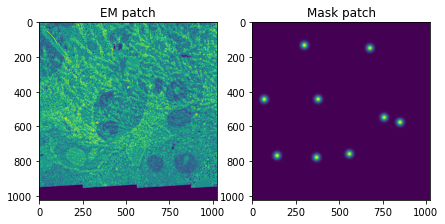

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,7))
ax1.imshow(example_data[:,:,0])
ax1.set_title('EM patch')
ax2.imshow(example_mask[:,:,0])
ax2.set_title('Mask patch')
plt.show()

Iterative Training
---

Now that the data is ready to be trained on, the iteration process can begin. First the background masks that were initially made are used in training, then the network will predict on the training set (also with the previously unlabeled segments.)
Then these predicions go through a thresholding function, and then used once more for training.

The idea is that if a network is already confident that a piece of the unlabeled parts of the image is background, that gets added to the training data.
The other half of the thresholding function deals with obvious false positives. These are way too large to represent single nuclei, and are therefore part of some other anatomy that the network identifies as a nucleus.


In [42]:
for i in range(iter_count):
    model_export = 'X:\\BEP_data\\Annotation_Iteration\\Models\\{}'.format(model_name)
    IMG_CHANNELS = (1,3)[TRAIN_WITH_FM]



    model, train_generator, test_generator = model_setup.Train_Model(ini_data_path + 'Annotation_Iteration\\', IMG_CHANNELS=IMG_CHANNELS,
                                                                     normalize=False, using_weights=True,)
    model.compile(optimizer='adam', loss=[MSE_loss_weighted], metrics=[bce_dice_loss_weighted])

    checkpointer = tf.keras.callbacks.ModelCheckpoint('{}.h5'.format('10jan1058'), verbose=1, save_best_only=True)
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=PATIENCE),
                 tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)]
    results = model.fit(train_generator, validation_data=test_generator, steps_per_epoch=len(train_list) // BATCH_SIZE,
                        validation_steps=len(test_list) // BATCH_SIZE,
                        epochs=1000, callbacks=callbacks, batch_size=BATCH_SIZE)
    model.save(model_export + '{}.h5'.format(i), include_optimizer=False)
    print('Done! Model can be found in ' + model_export)



    model_setup.scandirs('X:\\BEP_data\\Annotation_Iteration\\Predict_set')
    for img in glob(train_folder + '\\Train_data\\1\\*.png'):
        copy(img, predict_folder + '\\Input\\1')
    for img in glob(train_folder + '\\Test_data\\1\\*.png'):
        copy(img, predict_folder + '\\Input\\1')
    input_list = glob(predict_folder + '\\Input\\1\\*.png')


    model = tf.keras.models.load_model(model_export + '{}.h5'.format(i), compile=False)
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1. / 255
    )
    validation_generator = test_datagen.flow_from_directory(predict_folder + '\\Input\\',
                                                            target_size=(1024, 1024),
                                                            batch_size=4,
                                                            shuffle=False,
                                                            color_mode=('grayscale', 'rgb')[TRAIN_WITH_FM])

    output = model.predict(validation_generator)
    for j, pic in enumerate(output):
        cv2.imwrite(predict_folder + '\\Output\\{}'.format(input_list[j].split('\\')[-1]), pic * 255)

    model_setup.backup_data(data_paths, '*.png', model_name, 'X:\\BEP_data\\Annotation_Iteration\\Predict_set', 'X:\\BEP_data\\Annotation_Iteration\\Predict_backups', img_strs=input_list)

    radius_array = weights.get_radius_sample(mask_folder)
    mean_diam = np.mean(radius_array, dtype=int)

    area_threshold = area_thresh_scalar*np.pi*mean_diam//2*mean_diam//2

    for img_str in glob(predict_folder + '\\Output\\*.png'):
        mask_str = train_folder + '\\Train_masks\\1\\' + img_str.split('\\')[-1]
        mask = cv2.imread(mask_str)
        mask_back = mask[:,:,1]
        img = cv2.imread(img_str, cv2.IMREAD_GRAYSCALE)
        img_thresh = weights.background_from_pred(img, area_threshold)
        mask_thresh = np.maximum(img_thresh, mask_back)
        mask[:,:,1] = mask_thresh
        cv2.imwrite(mask_str, mask)

print('All done!')


Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 26 images belonging to 1 classes.
Found 26 images belonging to 1 classes.
Epoch 1/1000
25/25 [==============================] - 11s 405ms/step - loss: 0.2847 - bce_dice_loss_weighted: 0.8693 - val_loss: 0.2919 - val_bce_dice_loss_weighted: 0.8262

KeyboardInterrupt: 

Boy oh boy I hope this works